Reproduce the Physics Informed Deep Learning applied on Shrödinger Equation (https://github.com/maziarraissi/PINNs) with pytorch

In [49]:
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from pyDOE import lhs
import torch.nn.functional as F
device = "cuda:1"

In [50]:
class fc(nn.Module):

    def __init__(self, num_classes=2):
        super(fc, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.out = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.tanh(self.fc5(x))
        x = self.out(x)
        return x

In [63]:
class PINN():
    def __init__(self, x0, u0_star, v0_star, tb, lb, ub, t_f, x_f):
        self.x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True).to(device)
        self.t0 = torch.zeros_like(self.x0, dtype=torch.float32, requires_grad=True).to(device)
        self.u0_star = torch.tensor(u0_star, dtype=torch.float32).to(device)
        self.v0_star = torch.tensor(v0_star, dtype=torch.float32).to(device)
        self.tb = torch.tensor(tb, dtype=torch.float32, requires_grad=True).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float32, requires_grad=True).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32, requires_grad=True).to(device)
        self.t_f = torch.tensor(t_f, dtype=torch.float32, requires_grad=True).to(device)
        self.x_f = torch.tensor(x_f, dtype=torch.float32, requires_grad=True).to(device)

        self.criterion = torch.nn.MSELoss(reduction="mean")
        self.fc = fc().to(device)
        self.optimizer = torch.optim.LBFGS(
          self.fc.parameters(),
          lr=1.0,
          max_iter=10000,
          max_eval=10000,
          history_size=50,
          tolerance_grad=1e-5,
          tolerance_change=1.0 * np.finfo(float).eps,
          line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.optimizer_adam = torch.optim.Adam(self.fc.parameters(),lr=0.01)
        self.iter = 0

    
    def grad(self, h, x):
        return torch.autograd.grad(h, x, grad_outputs=torch.ones_like(h), create_graph=True, retain_graph=True)

    def latent_solution_h(self, x, t):
        input_xt = torch.concat((x, t), dim=1)
        uv = self.fc(input_xt)
        u, v = uv[:, [0]], uv[:, [1]]
        return u, v
    
    def shrodinger_equation(self, x, t):
        u, v = self.latent_solution_h(x, t)
        u_x = self.grad(u, x)[0]
        u_t = self.grad(u, t)[0]
        u_xx = self.grad(u_x, x)[0]
        v_x = self.grad(v, x)[0]
        v_xx = self.grad(v_x, x)[0]
        v_t = self.grad(v, t)[0]
        real = -v_t + 0.5*u_xx + (u**2 + v**2)*u
        imag = u_t + 0.5*v_xx + (u**2 + v**2)*v
        return real, imag

    def loss_function(self):
        self.optimizer.zero_grad()
        u0_pred, v0_pred = self.latent_solution_h(self.x0, self.t0)
        loss_initial_data = self.criterion(u0_pred, self.u0_star) + self.criterion(v0_pred, self.v0_star)
        u_tb_lb_pred, v_tb_lb_pred = self.latent_solution_h(self.lb, self.tb)
        u_tb_ub_pred, v_tb_ub_pred = self.latent_solution_h(self.ub, self.tb)
        u_tb_lb_pred_x = self.grad(u_tb_lb_pred, self.lb)[0]
        u_tb_ub_pred_x = self.grad(u_tb_ub_pred, self.ub)[0]
        v_tb_lb_pred_x = self.grad(v_tb_lb_pred, self.lb)[0]
        v_tb_ub_pred_x = self.grad(v_tb_ub_pred, self.ub)[0]
        loss_col_boundary = torch.mean((u_tb_lb_pred - u_tb_ub_pred)**2) + torch.mean((v_tb_lb_pred - v_tb_ub_pred)**2) + torch.mean((u_tb_lb_pred_x - u_tb_ub_pred_x)**2) + torch.mean((v_tb_lb_pred_x - v_tb_ub_pred_x)**2)
        real, imag = self.shrodinger_equation(self.x_f, self.t_f)
        loss_col_f = torch.mean(real**2) + torch.mean(imag**2)
        total_loss = loss_initial_data + loss_col_boundary + loss_col_f
        if self.iter % 50 ==0:
            print(f"Iter {self.iter}, Total Loss {total_loss}, Loss_0 {loss_initial_data}, Loss_b {loss_col_boundary}, Loss_f {loss_col_f}")
        self.iter += 1
        total_loss.backward()
        return total_loss
    
    def train(self, iter):
        self.fc.train()
        for i in range(iter):
            self.optimizer_adam.zero_grad()
            u0_pred, v0_pred = self.latent_solution_h(self.x0, self.t0)
            loss_initial_data = self.criterion(u0_pred, self.u0_star) + self.criterion(v0_pred, self.v0_star)
            u_tb_lb_pred, v_tb_lb_pred = self.latent_solution_h(self.lb, self.tb)
            u_tb_ub_pred, v_tb_ub_pred = self.latent_solution_h(self.ub, self.tb)
            u_tb_lb_pred_x = self.grad(u_tb_lb_pred, self.lb)[0]
            u_tb_ub_pred_x = self.grad(u_tb_ub_pred, self.ub)[0]
            v_tb_lb_pred_x = self.grad(v_tb_lb_pred, self.lb)[0]
            v_tb_ub_pred_x = self.grad(v_tb_ub_pred, self.ub)[0]
            loss_col_boundary = torch.mean((u_tb_lb_pred - u_tb_ub_pred)**2) + torch.mean((v_tb_lb_pred - v_tb_ub_pred)**2) + torch.mean((u_tb_lb_pred_x - u_tb_ub_pred_x)**2) + torch.mean((v_tb_lb_pred_x - v_tb_ub_pred_x)**2)
            real, imag = self.shrodinger_equation(self.x_f, self.t_f)
            loss_col_f = torch.mean(real**2) + torch.mean(imag**2)
            total_loss = loss_initial_data + loss_col_boundary + loss_col_f
            if self.iter % 50 ==0:
                print(f"Iter {self.iter}, Total Loss {total_loss}, Loss_0 {loss_initial_data}, Loss_b {loss_col_boundary}, Loss_f {loss_col_f}")
            self.iter += 1
            total_loss.backward()
            self.optimizer_adam.step()

        self.optimizer.step(self.loss_function)

    def predict(self, x, t):
        x = torch.tensor(x, requires_grad=True).float().to(device)
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.fc.eval()
        u, v = self.latent_solution_h(x, t)
        u_x = self.grad(u, x)[0]
        u_t = self.grad(u, t)[0]
        u_xx = self.grad(u_x, x)[0]
        v_x = self.grad(v, x)[0]
        v_xx = self.grad(v_x, x)[0]
        v_t = self.grad(v, t)[0]
        real = -v_t + 0.5*u_xx + (u**2 + v**2)*u
        imag = u_t + 0.5*v_xx + (u**2 + v**2)*v
        return u.detach().cpu().numpy(), v.detach().cpu().numpy(), real.detach().cpu().numpy(), imag.detach().cpu().numpy()




In [64]:
N_0 = 50
N_b = 50
N_f = 20000

lb = np.array([-5, 0])
ub = np.array([5, np.pi/2])
mat = sio.loadmat("./NLS.mat")
t = mat["tt"].reshape(-1, 1)
uu = mat["uu"]
x = mat["x"].reshape(-1, 1)
u = np.real(uu)
v = np.imag(uu)
h_gt = np.sqrt(u**2 + v**2)
X, T = np.meshgrid(x, t)
x0 = x.copy()
tb = t.copy()
train_x0_idx = np.random.choice(x0.shape[0], N_0, replace=False)
train_x0 = x0[train_x0_idx, :]
train_u0 = u[train_x0_idx, 0:1]
train_v0 = v[train_x0_idx, 0:1]
train_tb_idx = np.random.choice(tb.shape[0], N_b, replace=False)
train_tb = tb[train_tb_idx, :]
X_T_f = lb + (ub - lb)*lhs(2, N_f)

train_x_f = X_T_f[:, [0]]
train_t_f = X_T_f[:, [1]]
train_lb = -5 * np.ones_like(train_tb)
train_ub = 5 * np.ones_like(train_tb)

In [65]:
model = PINN(train_x0, train_u0, train_v0, train_tb, train_lb, train_ub, train_t_f, train_x_f)
model.train(2000)

Iter 0, Total Loss 0.7185763716697693, Loss_0 0.7103000283241272, Loss_b 0.007265892811119556, Loss_f 0.00101046497002244
Iter 50, Total Loss 0.12577396631240845, Loss_0 0.08468710631132126, Loss_b 0.001968196826055646, Loss_f 0.039118655025959015
Iter 100, Total Loss 0.07733955979347229, Loss_0 0.03920888900756836, Loss_b 0.003406221978366375, Loss_f 0.03472444415092468
Iter 150, Total Loss 0.06783238798379898, Loss_0 0.03428112715482712, Loss_b 0.003913410939276218, Loss_f 0.02963784895837307
Iter 200, Total Loss 0.04818747192621231, Loss_0 0.0244545117020607, Loss_b 0.00025858922163024545, Loss_f 0.023474369198083878
Iter 250, Total Loss 0.050396911799907684, Loss_0 0.025058194994926453, Loss_b 0.0017484185518696904, Loss_f 0.023590300232172012
Iter 300, Total Loss 0.04271148890256882, Loss_0 0.02066739648580551, Loss_b 0.0007728873752057552, Loss_f 0.021271206438541412
Iter 350, Total Loss 0.042301200330257416, Loss_0 0.01871163584291935, Loss_b 0.0004544139956124127, Loss_f 0.0231

In [66]:
X_T = np.hstack((X.flatten().reshape(-1, 1), T.flatten().reshape(-1, 1)))
U_pred = griddata(X_T, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_T, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_T, h_pred.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_T, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_T, f_v_pred.flatten(), (X, T), method='cubic')

/tmp/ipykernel_126296/2248455184.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


Text(0.5, 1.0, '$t = 0.98$')

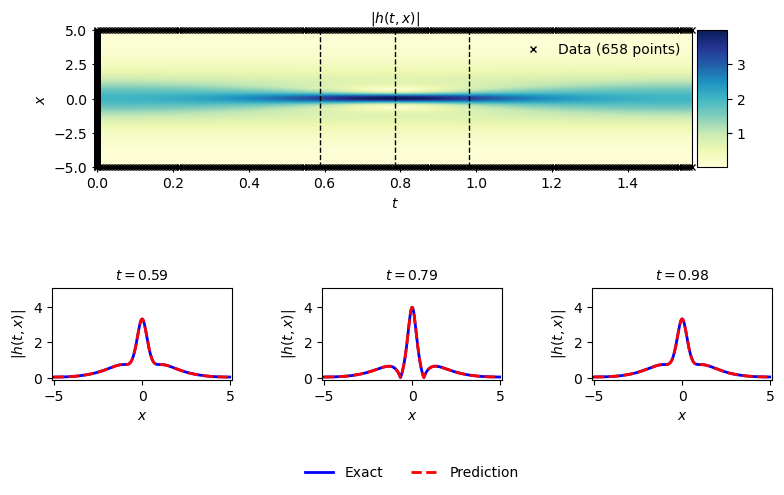

In [67]:
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,h_gt[:,75], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,h_gt[:,100], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,h_gt[:,125], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)